In [2]:
import pandas as pd
import numpy as np
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from scipy.stats import median_abs_deviation as MAD

from lago_model import LARS_model
from sklearn.linear_model import LinearRegression

from old_documents.functions import get_train_test

import statsmodels.api as sm
import holidays

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
def apply_func(df, func, cols_to_apply, bs=False):
    transformed_df = df.copy()
    for name, values in df.iteritems():
        if name in cols_to_apply:
            transformed_df[name] = func(values)
    return transformed_df


def mad_normalize_data(df_train, df_test, col, derived_columns):
    normalized_df_train = df_train.copy()
    normalized_df_test = df_test.copy()

    median = np.median(df_train[col])
    mad_price = MAD(df_train[col])

    for name in derived_columns:
            normalized_df_train[name] = (1/mad_price**2)*(normalized_df_train[name] - median)
            normalized_df_test[name] = (1/mad_price**2)*(normalized_df_test[name] - median)

    return median, mad_price, normalized_df_train, normalized_df_test 

def center_data(df_train, df_test, col, derived_columns):
    normalized_df_train = df_train.copy()
    normalized_df_test = df_test.copy()

    mean = np.mean(df_train[col])

    for name in derived_columns:
            if 'Week' not in name:
                normalized_df_train[name] = normalized_df_train[name]-mean
                normalized_df_test[name] = normalized_df_test[name]-mean
            else:
                normalized_df_train[name] = [row-mean if row!=0.0 else 0.0 for row in normalized_df_train[name]]
                normalized_df_test[name] = [row-mean if row!=0.0 else 0.0 for row in normalized_df_test[name]]

    return mean, normalized_df_train, normalized_df_test 

def standardizes_data_derived(df_train, df_test, col, derived_columns):
    normalized_df_train = df_train.copy()
    normalized_df_test = df_test.copy()
    
    mean = np.mean(df_train[col])
    sd = np.std(df_train[col])

    for name in derived_columns:
        normalized_df_train[name] = (normalized_df_train[name]-mean)/sd**2
        normalized_df_test[name] = (normalized_df_test[name]-mean)/sd**2
    
    return normalized_df_train, normalized_df_test

def standardizes_ind_cols(df_train, df_test, individual_cols):
    normalized_df_train = df_train.copy()
    normalized_df_test = df_test.copy()
    
    for name in individual_cols:
        mean = np.mean(df_train[name])
        sd = np.std(df_train[name])
        if np.round(mean)==0 and np.round(sd)==0 and 'solar' in name:
            pass
        else: 
            normalized_df_train[name] = (normalized_df_train[name]-mean)/sd**2
            normalized_df_test[name] = (normalized_df_test[name]-mean)/sd**2
    
    return normalized_df_train, normalized_df_test

def transformed_data(df_train, df_test, bs=False):
    # Availiable columns

    if bs:
        cols_from_price = [p for p in df_train.columns.values if "Price" in p] + [p for p in df_train.columns.values if 'Min' in p or 'Max' in p or 'Avg' in p]
        
        normalized_df_train = apply_func(df_train, np.arcsinh, cols_from_price, bs)
        normalized_df_test = apply_func(df_test , np.arcsinh, cols_from_price, bs)

        mean, normalized_df_train, normalized_df_test  = center_data(normalized_df_train, normalized_df_test, "Price", cols_from_price)

        return mean, normalized_df_train, normalized_df_test

    
    else:
        loaddk1_col = [p for p in df_train.columns.values if "Grid" in p]
        windprod_col = [p for p in df_train.columns.values if "Wind" in p]
        cols_from_price = [p for p in df_train.columns.values if "Price" in p]

        # Transform Y and Lags
        median, mad_price, normalized_df_train, normalized_df_test  = mad_normalize_data(df_train, df_test, "Price", cols_from_price)
        
        # Apply arcsinh
        normalized_df_train = apply_func(normalized_df_train, np.arcsinh, cols_from_price)
        normalized_df_test = apply_func(normalized_df_test , np.arcsinh, cols_from_price)

        # Standardize other variables
        normalized_df_train, normalized_df_test = standardizes_data_derived(normalized_df_train, normalized_df_test , 'Grid load forecast', loaddk1_col)
        normalized_df_train, normalized_df_test = standardizes_data_derived(normalized_df_train, normalized_df_test , 'Wind power forecast', windprod_col)
        
        return median, mad_price, normalized_df_train, normalized_df_test 

def rolling_window(model, df_train, df_test, X, Y, train_size=100, test_size=30, get_coef=False, bs=False):
    test_dates = pd.to_datetime(df_test['Date']).dt.date
    test_start = min(test_dates)
    test_end = max(test_dates)
    df_to_train = df_train.copy()
    pred_out = np.array([])
    
    iterations = np.ceil(((test_end-test_start).days+1)/test_size)
    print(f'Training {iterations} models', end='; \n')

    k = 1
    coef_count = np.zeros(len(X))
    while test_start <= test_end:
        train_dates = pd.to_datetime(df_to_train['Date']).dt.date
        train_start = test_start - timedelta(days=train_size)
        test_interval = test_start + timedelta(days=test_size)

        # Create train and test set
        df_to_train = df_to_train[train_dates >= train_start].copy()
        df_to_test = df_test[(test_dates >= test_start) & (test_dates < test_interval)].copy()

        # Transform data and fit model
        if bs:
            mean, df_to_train_norm, df_to_test_norm = transformed_data(df_to_train, df_to_test, bs)
        else:
            median, mad_price, df_to_train_norm, df_to_test_norm = transformed_data(df_to_train, df_to_test)
        
        model.fit(df_to_train_norm[X], df_to_train_norm[Y].values.ravel())
        if get_coef:
            coef = model.coef_
            coef_count[coef!=0] += 1

        print(k, end='\r')
        k += 1

        # Evaluate on test set
        pred_transformed = model.predict(df_to_test_norm[X])

        # Save predictions
        if bs:
            pred = np.sinh(pred_transformed+mean)
        else:
            pred = np.sinh(pred_transformed)*mad_price**2 + median
        pred_out = np.append(pred_out, pred)

        test_start = test_interval
        df_to_train = pd.concat([df_to_train, df_to_test])

    if get_coef:
        return pred_out, coef_count
    return pred_out

# y=sin(x)-mean -> invsin(y+mean)
def rolling_window_hourly(model, df_train, df_test, X, Y, train_size=100, test_size=30, print_res=True, get_coef=False, bs=False):
    preds = []

    counts = np.zeros((24, len(X[0])))
    for i in range(24):
        print(f'Hour {i}', end='; ')
        current_df = df_train.loc[df_train['Hour'] == i]
        current_df_test = df_test.loc[df_test['Hour'] == i]

        if get_coef:
            pred, coef_count = rolling_window(model, current_df, current_df_test, X[i], Y, train_size, test_size, get_coef)
            counts[i] = coef_count

        else:
            pred = rolling_window(model, current_df, current_df_test, X[i], Y, train_size, test_size, get_coef, bs)

        current_index = current_df_test.index
        preds.append(pd.Series(pred.reshape(1,-1)[0], current_index))
        
        if print_res:
            print('MAE', MAE(y_true = current_df_test[Y], y_pred = pred))
        else:
            print('')
    
    preds = pd.concat([*preds]).sort_index()
    print('Final results')

    plt.plot(range(len(df_test[Y])), df_test[Y])
    plt.plot(range(len(preds)), preds)
    plt.show()

    if print_res:
        print('MAE', MAE(y_true = df_test[Y], y_pred = preds))
        print('MSE', MSE(y_true = df_test[Y], y_pred = preds))
    
    if get_coef:
        return preds, counts
    
    return preds



def backward_selection(df_train, Y, no_go, train_size, cov_type="nonrobust", print_res=True):
    train_dates = pd.to_datetime(df_train['Date']).dt.date
    train_end = max(train_dates)
    train_start = train_end - timedelta(days=train_size)
    df_train = df_train[train_dates > train_start].copy()
    _, df_train, _ = transformed_data(df_train, df_train, bs=True)

    df_dropped = df_train.copy().drop(no_go + Y, axis=1)

    ex = sm.add_constant(df_dropped)
    step = 0
    while(True):
        step += 1 
        result = sm.OLS(df_train[Y], ex).fit(cov_type=cov_type)
        ar2 = result.rsquared
        pval = result.pvalues
        throw_away_index = np.argmax(result.pvalues)
        if pval[throw_away_index] >= 0.1:
            ex = ex.drop(pval.index[throw_away_index], axis=1)
            if print_res:
                print(f'step {step}', end= ': ')
                print(f'Adjusted R2: {ar2}', end= ', ')
                print(f'Candidate: {pval.index[throw_away_index]}', end= ', ')
                print(f'p-value: {pval[throw_away_index]}')
                print('===============')
        else:
            print('Final eval', end=': ')
            print(f'Adjusted R2: {ar2}')
            return ex.columns.values

# Lago Data (2013-2018)

Hour 0; Training 78.0 models; 
MAE 0.8311527566082718
Hour 1; Training 78.0 models; 
MAE 1.0794403267078012
Hour 2; Training 78.0 models; 
MAE 1.2791126222446543
Hour 3; Training 78.0 models; 
MAE 1.4357222685301583
Hour 4; Training 78.0 models; 
MAE 1.4446113827322762
Hour 5; Training 78.0 models; 
MAE 1.378422805897142
Hour 6; Training 78.0 models; 
MAE 1.562459258294537
Hour 7; Training 78.0 models; 
MAE 2.7474119968430326
Hour 8; Training 78.0 models; 
MAE 3.425683320552457
Hour 9; Training 78.0 models; 
MAE 2.845135556240024
Hour 10; Training 78.0 models; 
MAE 2.3460569751816256
Hour 11; Training 78.0 models; 
MAE 2.113050426653279
Hour 12; Training 78.0 models; 
MAE 1.955707677710786
Hour 13; Training 78.0 models; 
MAE 1.972338133741037
Hour 14; Training 78.0 models; 
MAE 2.049615312248812
Hour 15; Training 78.0 models; 
MAE 2.279099286408657
Hour 16; Training 78.0 models; 
MAE 2.8193626076368443
Hour 17; Training 78.0 models; 
MAE 3.3443931372269855
Hour 18; Training 78.0 models

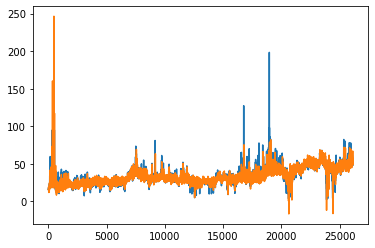

MAE 1.964535253517307
MSE 17.732255615705107


In [33]:
NP = pd.read_csv("data/full_NP_2018-13.csv", sep = ";")
NP['Hour']=pd.to_datetime(NP['DateTime']).dt.hour

no_go = ['Date', 'Price', 'Grid load forecast', 'Wind power forecast',
       'DateTime', 'Time', 'Lag_date_0', 'Lag_date_1', 'Lag_date_2',
       'Lag_date_3', 'Lag_date_7', "Hour"]


cols_from_price = [p for p in NP.columns.values if "Price" in p]

X = [col for col in NP.columns.values if col not in no_go]
X = [X for _ in range(24)]
Y = ['Price']

test = [2016,1,1]

df_train, df_test = get_train_test(NP, start=test, end=None, datetime_variable = 'DateTime', form='%Y-%m-%d %H:%M:%S')


model = LARS_model(max_iter = 2500, tol = 0.0001, selection="cyclic")
preds = rolling_window_hourly(model, df_train, df_test, X, Y, train_size=365*4, test_size=14)



# Uniejewski BS

## Create variables

In [4]:
NP = pd.read_csv("data/full_NP_2018-13.csv", sep = ";")
NP['Hour']=pd.to_datetime(NP['DateTime']).dt.hour

lag_cols = ['Price_lag1', 'Price_lag7', 'Grid load forecast', 'Grid load forecast_lag1', 'Grid load forecast_lag7', 'Wind power forecast']
for col in lag_cols:
    NP[col] = 1
    for i in range(24):
        NP[col][NP['Hour']==i] = NP[f'{col}_h{i}']

for lag in ['lag1', 'lag2', 'lag3']:
    plag = [col for col in NP.columns.values if 'Price' in col and lag in col and 'h' in col]
    NP['Min'+'_'+lag] = NP[plag].min(axis=1)
    NP['Max'+'_'+lag] = NP[plag].max(axis=1)
    NP['Avg'+'_'+lag] = NP[plag].mean(axis=1)

wlags = [col for col in NP.columns.values if 'Wind' in col and 'h' in col]
glags = [col for col in NP.columns.values if 'Grid' in col and 'h' in col]
p7lag = [col for col in NP.columns.values if 'Price' in col and 'lag7' in col and 'h' in col]

n_holidays = holidays.Norway(years = [2013, 2014, 2015, 2016, 2017, 2018]).keys()
def is_holiday(date):
    if date in n_holidays:
        return 1
    else:
        return 0
NP['Holiday'] = pd.to_datetime(NP['DateTime']).dt.date.apply(is_holiday)
week_cols = ['Week day_0', 'Week day_1', 'Week day_2', 'Week day_3', 'Week day_4', 'Week day_5', 'Week day_6']

for h_date in n_holidays:
    cur_row = NP[pd.to_datetime(NP['DateTime']).dt.date == h_date]
    for col in week_cols:
        NP[col][pd.to_datetime(NP['DateTime']).dt.date == h_date] = 0

mcols = ['Grid load forecast', 'Price_lag1']
for w in week_cols:
    for c in mcols:
        name = c+'_'+w
        NP[name] = NP[w] * NP[c]

no_go = ['Date', 'Price',
       'DateTime', 'Time', 'Lag_date_0', 'Lag_date_1', 'Lag_date_2',
       'Lag_date_3', 'Lag_date_7', "Hour", 'Price', 'Price_lag1', 'Holiday'] + wlags + glags + p7lag

X = [col for col in NP.columns.values if col not in no_go]

## BW

In [5]:
# BW
test = [2016,1,1]
df_train, df_test = get_train_test(NP, start=test, end=None, datetime_variable = 'DateTime', form='%Y-%m-%d %H:%M:%S')


train_size = 365*4
Y = ['Price']

cands = []
for i in range(24):
    print(f'Hour {i}')
    current_df = df_train.loc[df_train['Hour'] == i]
    cand = backward_selection(current_df, Y, no_go, train_size, print_res=False)
    cands.append(cand)

Hour 0
Final eval: Adjusted R2: 0.9794201353826985
Hour 1
Final eval: Adjusted R2: 0.9697196814098272
Hour 2
Final eval: Adjusted R2: 0.9590584961035126
Hour 3
Final eval: Adjusted R2: 0.9479818778440035
Hour 4
Final eval: Adjusted R2: 0.9425541461187409
Hour 5
Final eval: Adjusted R2: 0.9389618392379238
Hour 6
Final eval: Adjusted R2: 0.9389945366302426
Hour 7
Final eval: Adjusted R2: 0.9469129890758076
Hour 8
Final eval: Adjusted R2: 0.9373808128035818
Hour 9
Final eval: Adjusted R2: 0.9435545663531799
Hour 10
Final eval: Adjusted R2: 0.9458076965928716
Hour 11
Final eval: Adjusted R2: 0.9518010863470431
Hour 12
Final eval: Adjusted R2: 0.9563043725427288
Hour 13
Final eval: Adjusted R2: 0.9557912484070445
Hour 14
Final eval: Adjusted R2: 0.9525992994133906
Hour 15
Final eval: Adjusted R2: 0.9520028258476937
Hour 16
Final eval: Adjusted R2: 0.9536638873867918
Hour 17
Final eval: Adjusted R2: 0.950604468533305
Hour 18
Final eval: Adjusted R2: 0.9559960725368148
Hour 19
Final eval: Adj

## Train

Hour 0; Training 78.0 models; 
MAE 1.0372693003140367
Hour 1; Training 78.0 models; 
MAE 1.3047659970326864
Hour 2; Training 78.0 models; 
MAE 1.5942029837611855
Hour 3; Training 78.0 models; 
MAE 1.8047521153750863
Hour 4; Training 78.0 models; 
MAE 1.8717236352440454
Hour 5; Training 78.0 models; 
MAE 1.9130629539789452
Hour 6; Training 78.0 models; 
MAE 1.801272497529598
Hour 7; Training 78.0 models; 
MAE 2.618553351821461
Hour 8; Training 78.0 models; 
MAE 3.115826498163228
Hour 9; Training 78.0 models; 
MAE 2.6969882131984058
Hour 10; Training 78.0 models; 
MAE 2.2302679583448444
Hour 11; Training 78.0 models; 
MAE 2.052776038145319
Hour 12; Training 78.0 models; 
MAE 1.9538348648946555
Hour 13; Training 78.0 models; 
MAE 1.9641410516098505
Hour 14; Training 78.0 models; 
MAE 2.022493066951153
Hour 15; Training 78.0 models; 
MAE 2.1285081579319574
Hour 16; Training 78.0 models; 
MAE 2.491568003739766
Hour 17; Training 78.0 models; 
MAE 2.9585978570256213
Hour 18; Training 78.0 mod

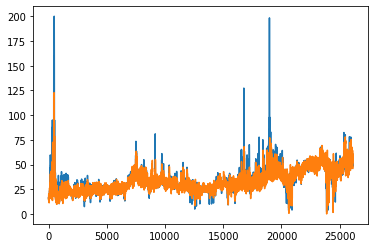

MAE 2.0018817745269866
MSE 15.915959438856243


0.060428312152230976

In [6]:
# Rolling window hourly
X = [[variable for variable in cand if 'const'!=variable] for cand in cands]
test_size = 14
model_lm = LinearRegression()
df_train, df_test = get_train_test(NP, start=test, datetime_variable = 'DateTime', form='%Y-%m-%d %H:%M:%S')

preds = rolling_window_hourly(model_lm, df_train, df_test, X, Y, train_size=train_size, test_size=test_size, print_res=True, bs=True)

df_test['Preds'] = preds
start_i = df_test[['DateTime','Week day_0']][df_test['Week day_0']==1].index.min()
max_i = df_test.index.max()
metric_w = []
end_i = 0
while end_i <= max_i:
    end_i = start_i + 24*7
    current_df = df_test.loc[start_i:end_i]
    p_mean = current_df['Price'].mean()
    mae_w = MAE(current_df['Preds'], current_df['Price'])
    metric_w.append(mae_w/p_mean)
    start_i = end_i + 1  

np.mean(metric_w) 

In [14]:
# Hourly
# Training
preds = []
X = [[variable for variable in cand if 'const'!=variable] for cand in cands]
test_size = 14
model_lm = LinearRegression()

df_train, df_test = get_train_test(NP, start=test, datetime_variable = 'DateTime', form='%Y-%m-%d %H:%M:%S')

mean, df_train_m, df_test_m = transformed_data(df_train, df_test, bs=True)

for i in range(24):
    current_df = df_train_m.loc[df_train_m['Hour'] == i]
    current_df_test = df_test_m.loc[df_test_m['Hour'] == i]

    model_lm.fit(current_df[X[i]], current_df[Y])
    pred_t = model_lm.predict(current_df_test[X[i]])

    pred = np.sinh(pred_t+ mean) 
    current_index = current_df_test.index
    preds.append(pd.Series(pred.reshape(1,-1)[0], current_index)) 

preds = pd.concat([*preds]).sort_index()

df_test['Preds'] = preds
start_i = df_test[['DateTime','Week day_0']][df_test['Week day_0']==1].index.min()
max_i = df_test.index.max()
metric_w = []
end_i = 0
while end_i <= max_i:
    end_i = start_i + 24*7
    current_df = df_test.loc[start_i:end_i]
    p_mean = current_df['Price'].mean()
    mae_w = MAE(current_df['Preds'], current_df['Price'])
    metric_w.append(mae_w/p_mean)
    start_i = end_i + 1  

print(MAE(current_df['Preds'], current_df['Price']))
print(np.sqrt(MSE(current_df['Preds'], current_df['Price'])))
np.mean(metric_w) 

2.3506566454216347
3.3136416913893822


0.06498062254612814